In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

/kaggle/input/hwdata/train.csv
/kaggle/input/hwdata/test.csv
cuda


In [2]:
!pip install rouge
!pip install nltk==3.8.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 19.9 MB/s eta 0:00:0000:010:01
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.8.1 which is incompatible.


# Handle data

In [3]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, IterableDataset

PAD_TOKEN = 0
SOS_TOKEN = 1
EOS_TOKEN = 2
UNK_TOKEN = 3

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class Vocabulary:
    """
    Make map and build vocabulary, using integer encoding
    """

    def __init__(self):
        self.word2index = {}
        self.index2word = {
            PAD_TOKEN: "PAD",
            SOS_TOKEN: "SOS",
            EOS_TOKEN: "EOS",
            UNK_TOKEN: "UNK",
        }
        self.nums = 4
        # self.max_length = 0

    def add_sentence(self, sentence):
        list_sentence = sentence.split(" ")
        # if len(list_sentence) > self.max_length:
        #     self.max_length = len(list_sentence) + 2  # including <SOS> and <EOS>
        for word in list_sentence:
            self._add_word(word)

    def sentence2index(self, sentence):
        return [
            self.word2index[word] if word in self.word2index else UNK_TOKEN
            for word in sentence.split(" ")
        ]

    def _add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.nums
            self.index2word[self.nums] = word
            self.nums += 1


class MyIterableDataset(IterableDataset):
    """
    To build dynamic length of dataset
    """

    def __init__(self, dataset, source_voc, target_voc):
        self.dataset = dataset
        self.source_voc = source_voc
        self.target_voc = target_voc

    def __iter__(self):
        for _, sample in self.dataset.iterrows():
            one_source_idx = self.source_voc.sentence2index(sample["description"])
            one_target_idx = self.target_voc.sentence2index(sample["diagnosis"])

            one_source_idx.insert(0, SOS_TOKEN)
            one_source_idx.append(EOS_TOKEN)

            one_target_idx.insert(0, SOS_TOKEN)
            one_target_idx.append(EOS_TOKEN)

            yield one_source_idx, one_target_idx

    def __len__(self):
        return len(self.dataset)


class DataHandler:
    def __init__(self, batch_size):
        self.batch_size = batch_size
        raw_train_dataset = (
            pd.read_csv("/kaggle/input/hwdata/train.csv")
            .sample(frac=1, random_state=42)
            .reset_index(drop=True)
        )
        self.test_dataset = pd.read_csv("/kaggle/input/hwdata/test.csv")

        # Split data
        train_ratio = 0.8
        train_size = int(len(raw_train_dataset) * train_ratio)

        self.train_dataset = raw_train_dataset.iloc[:train_size]
        self.val_dataset = raw_train_dataset.iloc[train_size:]

        # Build vocabulary
        self.source_voc = Vocabulary()
        self.target_voc = Vocabulary()

        for sentence in self.train_dataset["description"]:
            self.source_voc.add_sentence(sentence)
        for sentence in self.train_dataset["diagnosis"]:
            self.target_voc.add_sentence(sentence)

    def get_dataloader(self):
        return (
            self._get_dataloader(self.train_dataset),
            self._get_dataloader(self.val_dataset),
            self._get_dataloader(self.test_dataset),
        )

    def _get_dataloader(self, dataset):
        """
        Transform dataset to dataloader in pytorch
        """
        iterable_dataset = MyIterableDataset(dataset, self.source_voc, self.target_voc)

        loader = DataLoader(
            iterable_dataset,
            batch_size=self.batch_size,
            collate_fn=self._collate_fn,
        )
        return loader

    @staticmethod
    def _collate_fn(batch):
        """
        Used to padding according to the batch samples, which will decrease the inputdim
        """
        max_source_len = max(len(sample[0]) for sample in batch)
        max_target_len = max(len(sample[1]) for sample in batch)

        padded_batch = []
        for source_idx, target_idx in batch:
            padded_source_idx = source_idx + [PAD_TOKEN] * (
                max_source_len - len(source_idx)
            )
            padded_target_idx = target_idx + [PAD_TOKEN] * (
                max_target_len - len(target_idx)
            )

            padded_batch.append((padded_source_idx, padded_target_idx))

        source_tensor = torch.LongTensor([sample[0] for sample in padded_batch]).to(
            DEVICE
        )
        target_tensor = torch.LongTensor([sample[1] for sample in padded_batch]).to(
            DEVICE
        )

        return source_tensor, target_tensor


# Define model

In [4]:
import torch
from torch import nn



class Encoder(nn.Module):
    def __init__(
        self,
        input_dim,
        hid_dim,
        n_layers,
        n_heads,
        ff_dim,
        dropout,
        max_length=150,
    ):
        """
        Args:
            input_dim: size of input vocabulary
            hid_dim: embedding dimension
            ff_dim: feedforward dimension
            n_heads: head of MultiHeadAttentionLayer
            max_length: size of max token nums of sentence
        """
        super().__init__()

        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        # the position embedding is learnt
        self.pos_embedding = nn.Embedding(max_length, hid_dim)

        self.layers = nn.ModuleList(
            [EncoderLayer(hid_dim, n_heads, ff_dim, dropout) for _ in range(n_layers)]
        )

        self.dropout = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(DEVICE)

    def forward(self, src, src_mask):
        """
        Args:
            src_mask: used to mask padding token
        """
        # src = [batch size, src len]
        # src_mask = [batch size, 1, 1, src len]
        batch_size = src.shape[0]
        src_len = src.shape[1]

        # pos = [batch size, src len]
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(DEVICE)

        # the scale is used to reduces variance
        src = self.dropout(
            (self.tok_embedding(src) * self.scale) + self.pos_embedding(pos)
        )

        # src = [batch size, src len, hid dim]
        for layer in self.layers:
            src = layer(src, src_mask)

        return src


class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, ff_dim, dropout):
        super().__init__()

        self.attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(
            hid_dim, ff_dim, dropout
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask):
        # src = [batch size, src len, hid dim]
        # three linear transformation
        _src, _ = self.self_attention(src, src, src, src_mask)

        # give dropout of attention, and add residual connection and layer norm
        src = self.attn_layer_norm(src + self.dropout(_src))

        # positionwise feedforward
        _src = self.positionwise_feedforward(src)

        # the same of previous
        src = self.ff_layer_norm(src + self.dropout(_src))

        return src


class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout):
        super().__init__()

        assert hid_dim % n_heads == 0

        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads

        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)

        self.fc_o = nn.Linear(hid_dim, hid_dim)

        self.dropout = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(DEVICE)

    def forward(self, query, key, value, mask=None):
        """
        Return:
            x: contain the contextual information
            attention: attention distribution
        """
        batch_size = query.shape[0]

        # three linear transformation
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        """Copy the Q, K, V with head nums"""
        # Q = [batch size, query len, hid dim]
        # K = [batch size, key len, hid dim]
        # V = [batch size, value len, hid dim]
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        # Q = [batch size, n heads, query len, head dim]
        # K = [batch size, n heads, key len, head dim]
        # V = [batch size, n heads, value len, head dim]

        # Q * K.T
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        # energy = [batch size, n heads, query len, key len]

        if mask is not None:
            energy = energy.masked_fill(
                mask == 0, -1e10
            )  # replace with -1e10 to make softmax work

        # get attention distribution
        attention = torch.softmax(energy, dim=-1)
        # attention = [batch size, n heads, query len, key len]

        x = torch.matmul(self.dropout(attention), V)
        # x = [batch size, n heads, query len, head dim]

        """concat the results"""
        x = x.permute(0, 2, 1, 3).contiguous()
        # x = [batch size, query len, n heads, head dim]

        x = x.view(batch_size, -1, self.hid_dim)
        # x = [batch size, query len, hid dim]

        # linear transform to result
        x = self.fc_o(x)
        # x = [batch size, query len, hid dim]

        return x, attention


class PositionwiseFeedforwardLayer(nn.Module):
    """
    hid_dim --relu, dropout--> ff_dim --> hid_dim
    """

    def __init__(self, hid_dim, ff_dim, dropout):
        super().__init__()

        self.fc_1 = nn.Linear(hid_dim, ff_dim)
        self.fc_2 = nn.Linear(ff_dim, hid_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # the BERT model uses GELU
        x = self.dropout(torch.relu(self.fc_1(x)))
        x = self.fc_2(x)

        return x


class Decoder(nn.Module):
    def __init__(
        self,
        output_dim,
        hid_dim,
        n_layers,
        n_heads,
        ff_dim,
        dropout,
        max_length=150,
    ):
        super().__init__()

        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)

        self.layers = nn.ModuleList(
            [DecoderLayer(hid_dim, n_heads, ff_dim, dropout) for _ in range(n_layers)]
        )

        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(DEVICE)

    def forward(self, trg, enc_src, trg_mask, src_mask):
        # trg = [batch size, trg len]
        # enc_src = [batch size, src len, hid dim]
        # trg_mask = [batch size, 1, trg len, trg len]
        # src_mask = [batch size, 1, 1, src len]
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]

        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(DEVICE)

        trg = self.dropout(
            (self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos)
        )

        attention = None
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        output = self.fc_out(trg)
        # output = [batch size, trg len, output dim]
        return output, attention


class DecoderLayer(nn.Module):
    def __init__(
        self,
        hid_dim,
        n_heads,
        ff_dim,
        dropout,
    ):
        super().__init__()

        self.attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(
            hid_dim, ff_dim, dropout
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, trg, enc_src, trg_mask, src_mask):
        # trg = [batch size, trg len, hid dim]
        # enc_src = [batch size, src len, hid dim]
        # trg_mask = [batch size, 1, trg len, trg len]
        # src_mask = [batch size, 1, 1, src len]

        # self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)

        # dropout, residual connection and layer norm
        trg = self.attn_layer_norm(trg + self.dropout(_trg))

        # encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)

        # dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))

        # positionwise feedforward
        _trg = self.positionwise_feedforward(trg)

        # dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))

        return trg, attention


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder

    def make_src_mask(self, src):
        # src = [batch size, src len]
        src_mask = (src != PAD_TOKEN).unsqueeze(1).unsqueeze(2)
        # src_mask = [batch size, 1, 1, src len]

        return src_mask

    def make_trg_mask(self, trg):
        # trg = [batch size, trg len]
        trg_pad_mask = (trg != PAD_TOKEN).unsqueeze(1).unsqueeze(2)
        # trg_pad_mask = [batch size, 1, 1, trg len]

        trg_len = trg.shape[1]
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device=DEVICE)).bool()
        # trg_sub_mask = [trg len, trg len]

        trg_mask = trg_pad_mask & trg_sub_mask

        # trg_mask = [batch size, 1, trg len, trg len]
        return trg_mask

    def forward(self, src, trg):
        # src = [batch size, src len]
        # trg = [batch size, trg len]

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        enc_src = self.encoder(src, src_mask)
        # enc_src = [batch size, src len, hid dim]

        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        # output = [batch size, trg len, output dim]
        # attention = [batch size, n heads, trg len, src len]
        return output, attention


# Train model

In [16]:
import math
import random

import nltk
import numpy as np
import torch
from matplotlib import pyplot as plt
from nltk.translate.meteor_score import meteor_score
from rouge import Rouge
from torch import optim
from torch.nn.utils.clip_grad import clip_grad_norm_
from torchtext.data.metrics import bleu_score
from tqdm import tqdm

download_path = "/kaggle/working/nltk_data"
model_save_path = "/kaggle/working/model.pt"
result_save_path = "/kaggle/working/result.csv"
nltk.download("wordnet", download_dir=download_path)
nltk.data.path.append(download_path)



def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


class Model:
    def __init__(
        self,
        learning_rate=0.001,
        max_epochs=30,
        batch_size=128,
        hidden_dim=128,
        ff_dim=512,
        n_layers=4,
        heads=8,
        dropout=0.2,
        optimizer="adam",
    ):
        set_seed(42)
        self.epochs = max_epochs
        self.batch_size = batch_size

        self.data_handler = DataHandler(batch_size)
        (
            self.train_loader,
            self.val_loader,
            self.test_loader,
        ) = self.data_handler.get_dataloader()

        # Record loss
        # self.train_loss = []
        # self.val_loss = []
        #
        # self.train_accuracy = []
        # self.val_accuracy = []
        # self.test_result = None

        # Define model
        self.enc = Encoder(
            self.data_handler.source_voc.nums,
            hidden_dim,
            n_layers,
            heads,
            ff_dim,
            dropout,
        )
        self.dec = Decoder(
            self.data_handler.target_voc.nums,
            hidden_dim,
            n_layers,
            heads,
            ff_dim,
            dropout,
        )
        self.model = Seq2Seq(self.enc, self.dec).to(DEVICE)

        if optimizer == "adam":
            self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        elif optimizer == "adamw":
            self.optimizer = optim.AdamW(self.model.parameters(), lr=learning_rate)
        elif optimizer == "sgd":
            self.optimizer = optim.SGD(self.model.parameters(), lr=learning_rate)

        # ignore padding token
        self.criterion = nn.CrossEntropyLoss(ignore_index=PAD_TOKEN)

        def initialize_weights(m):
            if hasattr(m, "weight") and m.weight.dim() > 1:
                nn.init.xavier_uniform_(m.weight.data)

        self.model.apply(initialize_weights)

    def train(self, verbose=True):
        self.train_loss = []
        self.val_loss = []

        if verbose:
            print("===== Traning Info =====")
            print("Device:", DEVICE)
            print("Batch size:", self.batch_size)
            print(f"Model Info:\n")
            # print(self.model)

            def count_parameters(model):
                return sum(p.numel() for p in model.parameters() if p.requires_grad)

            print(
                f"The model has {count_parameters(self.model):,} trainable parameters"
            )
            print("\n==== Starting Train ====")

        best_valid_loss = float("inf")
        early_stop_patience = 3
        early_stop_count = 0
        epoch = 0

        for epoch in range(1, self.epochs + 1):
            self._epoch_train(epoch, verbose)
            valid_loss = self._evaluate(self.val_loader, verbose)
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                torch.save(self.model.state_dict(), model_save_path)
                early_stop_count = 0
            else:
                early_stop_count += 1
                if early_stop_count == early_stop_patience:
                    if verbose:
                        print("Early stop...")
                    break

        if verbose:
            print(f"The training epoch is {epoch}")
            print(f"Choose model with best valid loss: {best_valid_loss}")
        self.model.load_state_dict(torch.load(model_save_path))
        self._evaluate(self.test_loader, True)

        def moving_average(data, window_size):
            weights = np.repeat(1.0, window_size) / window_size
            smoothed_data = np.convolve(data, weights, "valid")
            return smoothed_data

        window_size = 10
        self.train_loss = moving_average(self.train_loss, window_size)
        self.val_loss = moving_average(self.val_loss, window_size)
        return best_valid_loss, epoch

    def _epoch_train(self, epoch, verbose):
        self.model.train()
        epoch_loss = 0
        for source, target in tqdm(self.train_loader, disable=not verbose):
            self.optimizer.zero_grad()
            # trim the last token
            output, _ = self.model(source, target[:, :-1])

            output = output.contiguous().view(-1, output.shape[-1])
            # trim the first token
            target = target[:, 1:].contiguous().view(-1)

            loss = self.criterion(output, target)
            loss.backward()

            # used to prevent gradient explosion
            clip_grad_norm_(self.model.parameters(), 1)

            self.optimizer.step()

            self.train_loss.append(loss.item())
            epoch_loss += loss.item()

        epoch_loss /= len(self.train_loader)
        if verbose:
            print(f"Train Epoch {epoch}")
            print(
                "Train set: \nLoss: {} PPL: {}".format(epoch_loss, math.exp(epoch_loss))
            )

    def _evaluate(self, dataset, verbose):
        self.model.eval()
        epoch_loss = 0

        with torch.no_grad():
            for source, target in dataset:
                self.optimizer.zero_grad()
                output, _ = self.model(source, target[:, :-1])

                output = output.contiguous().view(-1, output.shape[-1])
                # trim the first token
                target = target[:, 1:].contiguous().view(-1)

                loss = self.criterion(output, target)

                if dataset == self.val_loader:
                    self.val_loss.append(loss.item())
                epoch_loss += loss.item()

        epoch_loss /= len(dataset)
        if verbose:
            if dataset == self.val_loader:
                print(f"Val set: \nLoss: {epoch_loss} PPL: {math.exp(epoch_loss)}\n")
            else:
                print(f"Test set: \nLoss: {epoch_loss} PPL: {math.exp(epoch_loss)}\n")
        return epoch_loss

    def _inference(self, sentence, max_len):
        self.model.eval()

        source_index = self.data_handler.source_voc.sentence2index(sentence)
        source_index.insert(0, SOS_TOKEN)
        source_index.append(EOS_TOKEN)

        source_tensor = torch.LongTensor(source_index).unsqueeze(0).to(DEVICE)
        source_mask = self.model.make_src_mask(source_tensor)

        predicts = [SOS_TOKEN]

        # get contextual information
        with torch.no_grad():
            enc_src = self.model.encoder(source_tensor, source_mask)

        for _ in range(max_len):
            target_tensor = torch.LongTensor(predicts).unsqueeze(0).to(DEVICE)
            target_mask = self.model.make_trg_mask(target_tensor)

            with torch.no_grad():
                output, _ = self.model.decoder(
                    target_tensor, enc_src, target_mask, source_mask
                )
            pred_token = output.argmax(2)[:, -1].item()
            predicts.append(pred_token)
            if pred_token == EOS_TOKEN:
                break
        predicts = [self.data_handler.target_voc.index2word[idx] for idx in predicts]
        return predicts

    def metric(self, head, verbose=True):
        print("\n==== Calculating metrics ====")
        reference = []
        candidate = []
        sources = self.data_handler.test_dataset["description"].tolist()
        targets = self.data_handler.test_dataset["diagnosis"].tolist()
        rouge = Rouge()
        rouge_l_f = 0
        rouge_1_f = 0
        rouge_2_f = 0
        meteor = 0

        for i in tqdm(range(len(sources)), disable=not verbose):
            reference.append([targets[i].split(" ")])
            predict = self._inference(
                sources[i], max_len=len(targets[i].split(" ")) + 10
            )
            candidate.append(predict[1:-1])  # cut SOS_TOKEN and EOS_TOKEN

            rouge_score = rouge.get_scores(" ".join(predict[1:-1]), targets[i])[0]
            rouge_l_f += rouge_score["rouge-l"]["f"]  # type: ignore
            rouge_1_f += rouge_score["rouge-1"]["f"]  # type: ignore
            rouge_2_f += rouge_score["rouge-2"]["f"]  # type: ignore
            meteor += meteor_score(reference[-1], candidate[-1])

            if i < head:
                print(f"Reference: {reference[-1]}")
                print(f"Predict: {predict}")

        bleu = bleu_score(candidate, reference)
        meteor /= len(sources)
        rouge_l_f /= len(sources)
        rouge_1_f /= len(sources)
        rouge_2_f /= len(sources)

        if verbose:
            print(f"BLEU: {bleu}")
            print(f"Meteor: {meteor}")
            print(f"ROUGE-L f1: {rouge_l_f}")
            print(f"ROUGE-1 f1: {rouge_1_f}")
            print(f"ROUGE-2 f1: {rouge_2_f}")
        return bleu, meteor, rouge_l_f, rouge_1_f, rouge_2_f

    def draw_loss(self):
        plt.plot(self.train_loss, label="Smoothed train Loss")
        plt.plot(self.val_loss, label="Smoothed val Loss")
        plt.title("Loss")
        plt.legend()
        plt.show()
        
    def save_result(self):
        results = pd.DataFrame(columns=["diagnosis"])
        sources = self.data_handler.test_dataset["description"].tolist()
        targets = self.data_handler.test_dataset["diagnosis"].tolist()

        for i in tqdm(range(len(sources))):
            predict = self._inference(
                sources[i], max_len=len(targets[i].split(" ")) + 10
            )
            # row = {"diagnosis": " ".join(predict[1:-1])}
            results.loc[results.index.size] = " ".join(predict[1:-1])

        results.to_csv(result_save_path)

[nltk_data] Downloading package wordnet to
[nltk_data]     /kaggle/working/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
!unzip -f /kaggle/working/nltk_data/corpora/wordnet.zip -d /kaggle/working/nltk_data/corpora/

Archive:  /kaggle/working/nltk_data/corpora/wordnet.zip


# Do the train/analyse

## Compare optimizer

===== Adam =====
Test set: 
Loss: 1.8931042328476906 PPL: 6.639948668744483

Training time:  352.7833306789398

==== Calculating metrics ====


100%|██████████| 2000/2000 [03:27<00:00,  9.66it/s]


BLEU: 0.24104311199032058
Meteor: 0.4517784619987046
ROUGE-L f1: 0.4991864832821213
ROUGE-1 f1: 0.5246898719862375
ROUGE-2 f1: 0.3488097139859169

===== Adamw =====
Test set: 
Loss: 1.8963283151388168 PPL: 6.661390956938338

Training time:  334.6842534542084

==== Calculating metrics ====


100%|██████████| 2000/2000 [03:24<00:00,  9.80it/s]


BLEU: 0.23119275300766715
Meteor: 0.4433146273998802
ROUGE-L f1: 0.4938417383953344
ROUGE-1 f1: 0.5192320491876691
ROUGE-2 f1: 0.34349004193198734

===== Sgd =====
Test set: 
Loss: 5.546360343694687 PPL: 256.30300137378424

Training time:  547.4291903972626

==== Calculating metrics ====


100%|██████████| 2000/2000 [05:55<00:00,  5.63it/s]


BLEU: 0.0
Meteor: 0.031558953475121575
ROUGE-L f1: 0.09707010334550013
ROUGE-1 f1: 0.09707010334550013
ROUGE-2 f1: 0.0


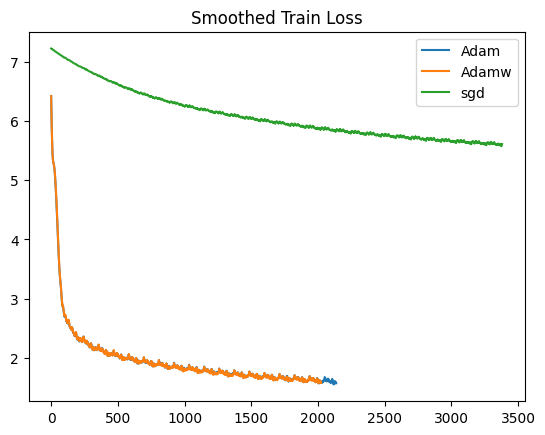

In [14]:
import time

from matplotlib import pyplot as plt


if __name__ == "__main__":
    model_adam = Model(optimizer="adam")
    model_adamw = Model(optimizer="adamw")
    model_sgd = Model(optimizer="sgd")

    print("===== Adam =====")
    start_time = time.time()
    model_adam.train(verbose=False)
    end_time = time.time()
    print("Training time: ", end_time - start_time)
    model_adam.metric(0)

    print("\n===== Adamw =====")
    start_time = time.time()
    model_adamw.train(verbose=False)
    end_time = time.time()
    print("Training time: ", end_time - start_time)
    model_adamw.metric(0)

    print("\n===== Sgd =====")
    start_time = time.time()
    model_sgd.train(verbose=False)
    end_time = time.time()
    print("Training time: ", end_time - start_time)
    model_sgd.metric(0)

    # show plt
    plt.plot(model_adam.train_loss, label="Adam")
    plt.plot(model_adamw.train_loss, label="Adamw")
    plt.plot(model_sgd.train_loss, label="sgd")
    plt.title("Smoothed Train Loss")
    plt.legend()
    plt.show()

## Choose params

In [7]:
import json

from tqdm import tqdm


def explore_hyperparameters(param_grid, current_params={}, all_params=[]):
    if not param_grid:
        all_params.append(current_params)
        return {}

    current_param, remaining_params = list(param_grid.items())[0]
    for value in remaining_params:
        updated_params = current_params.copy()
        updated_params[current_param] = value
        explore_hyperparameters(
            dict(list(param_grid.items())[1:]), updated_params, all_params
        )

    return all_params


param_grid = {
    "learning_rate": [0.001, 0.0005, 0.0001],
    "hidden_dim": [128, 256],
    "ff_dim": [512, 1024],
    "n_layers": [2, 4],
    "dropout": [0.2, 0.5],
}

all_params = explore_hyperparameters(param_grid)

results = []
for params in tqdm(all_params):
    model = Model(**params)
    valid_loss, train_epoch = model.train(verbose=False)
    bleu, meteor, rouge_l, rouge_1, rouge_2 = model.metric(0, verbose=False)
    metrics = {
        "valid_loss": valid_loss,
        "bleu": bleu,
        "meteor": meteor,
        "rouge_l": rouge_l,
        "rouge_1": rouge_1,
        "rouge_2": rouge_2,
    }
    params["epoches"] = train_epoch
    results.append([params, metrics])

# sort according to valid_loss
results = sorted(results, key=lambda x: x[1]["valid_loss"])
best_params = results[0][0]
best_metrics = results[0][1]

print("The best params is:")
print(f"learning_rate: {best_params['learning_rate']}")
print(f"epoches: {best_params['epoches']}")
print(f"hidden_dim: {best_params['hidden_dim']}")
print(f"ff_dim: {best_params['ff_dim']}")
print(f"n_layers: {best_params['n_layers']}")
print(f"dropout: {best_params['dropout']}")

print("\nThe best metrics is:")
print(f"valid_loss: {best_metrics['valid_loss']}")
print(f"bleu: {best_metrics['bleu']}")
print(f"meteor: {best_metrics['meteor']}")
print(f"rouge_l: {best_metrics['rouge_l']}")
print(f"rouge_1: {best_metrics['rouge_1']}")
print(f"rouge_2: {best_metrics['rouge_2']}")

# save total results
with open("/kaggle/working/choose_param.json", "w") as file:
    json.dump(results, file, indent=2, separators=(", ", ": "))

  0%|          | 0/48 [00:00<?, ?it/s]

Test set: 
Loss: 1.864612102508545 PPL: 6.453432130287726


==== Calculating metrics ====


  2%|▏         | 1/48 [05:55<4:38:50, 355.98s/it]

Test set: 
Loss: 2.1227456778287888 PPL: 8.354043539104746


==== Calculating metrics ====


  4%|▍         | 2/48 [12:54<5:01:13, 392.89s/it]

Test set: 
Loss: 1.8931042328476906 PPL: 6.639948668744483


==== Calculating metrics ====


  6%|▋         | 3/48 [22:05<5:48:35, 464.79s/it]

Test set: 
Loss: 2.096116006374359 PPL: 8.134514076010126


==== Calculating metrics ====


  8%|▊         | 4/48 [33:47<6:49:42, 558.70s/it]

Test set: 
Loss: 1.857009120285511 PPL: 6.40455285012937


==== Calculating metrics ====


 10%|█         | 5/48 [39:33<5:45:28, 482.05s/it]

Test set: 
Loss: 2.0834997668862343 PPL: 8.032531767623228


==== Calculating metrics ====


 12%|█▎        | 6/48 [47:08<5:30:52, 472.67s/it]

Test set: 
Loss: 1.9040464609861374 PPL: 6.713003464107081


==== Calculating metrics ====


 15%|█▍        | 7/48 [57:10<5:51:51, 514.90s/it]

Test set: 
Loss: 2.0618801414966583 PPL: 7.860735219920451


==== Calculating metrics ====


 17%|█▋        | 8/48 [1:10:33<6:44:22, 606.57s/it]

Test set: 
Loss: 1.8801591470837593 PPL: 6.554547916375683


==== Calculating metrics ====


 19%|█▉        | 9/48 [1:15:24<5:30:14, 508.06s/it]

Test set: 
Loss: 2.110247626900673 PPL: 8.250284023960143


==== Calculating metrics ====


 21%|██        | 10/48 [1:22:00<4:59:47, 473.34s/it]

Test set: 
Loss: 1.934815302491188 PPL: 6.922765319783618


==== Calculating metrics ====


 23%|██▎       | 11/48 [1:31:13<5:07:00, 497.86s/it]

Test set: 
Loss: 4.887617886066437 PPL: 132.63724041098968


==== Calculating metrics ====


 25%|██▌       | 12/48 [1:39:05<4:54:00, 490.02s/it]

Test set: 
Loss: 1.8802666068077087 PPL: 6.555252304131369


==== Calculating metrics ====


 27%|██▋       | 13/48 [1:43:58<4:11:03, 430.38s/it]

Test set: 
Loss: 2.063902512192726 PPL: 7.876648626458498


==== Calculating metrics ====


 29%|██▉       | 14/48 [1:53:47<4:30:59, 478.23s/it]

Test set: 
Loss: 4.7778617441654205 PPL: 118.84994656020503


==== Calculating metrics ====


 31%|███▏      | 15/48 [2:02:26<4:29:48, 490.56s/it]

Test set: 
Loss: 5.236904740333557 PPL: 188.08702230510778


==== Calculating metrics ====


 33%|███▎      | 16/48 [2:10:07<4:16:54, 481.71s/it]

Test set: 
Loss: 1.8598404452204704 PPL: 6.422711915287334


==== Calculating metrics ====


 35%|███▌      | 17/48 [2:16:39<3:54:51, 454.58s/it]

Test set: 
Loss: 2.115479663014412 PPL: 8.293562927588404


==== Calculating metrics ====


 38%|███▊      | 18/48 [2:23:45<3:42:57, 445.90s/it]

Test set: 
Loss: 1.8816127628087997 PPL: 6.564082638529581


==== Calculating metrics ====


 40%|███▉      | 19/48 [2:34:58<4:08:32, 514.23s/it]

Test set: 
Loss: 2.065358117222786 PPL: 7.88812226433584


==== Calculating metrics ====


 42%|████▏     | 20/48 [2:47:32<4:33:33, 586.19s/it]

Test set: 
Loss: 1.85014658421278 PPL: 6.360751840069817


==== Calculating metrics ====


 44%|████▍     | 21/48 [2:54:36<4:01:50, 537.43s/it]

Test set: 
Loss: 2.0962683632969856 PPL: 8.135753519958344


==== Calculating metrics ====


 46%|████▌     | 22/48 [3:02:15<3:42:45, 514.06s/it]

Test set: 
Loss: 1.8666450306773186 PPL: 6.466564838654141


==== Calculating metrics ====


 48%|████▊     | 23/48 [3:14:56<4:05:05, 588.20s/it]

Test set: 
Loss: 2.0474430173635483 PPL: 7.748064090317125


==== Calculating metrics ====


 50%|█████     | 24/48 [3:28:23<4:21:31, 653.81s/it]

Test set: 
Loss: 1.8590962067246437 PPL: 6.417933664132152


==== Calculating metrics ====


 52%|█████▏    | 25/48 [3:34:20<3:36:28, 564.71s/it]

Test set: 
Loss: 2.08111559599638 PPL: 8.013403650621678


==== Calculating metrics ====


 54%|█████▍    | 26/48 [3:41:36<3:12:52, 526.04s/it]

Test set: 
Loss: 1.8864535987377167 PPL: 6.595935320207366


==== Calculating metrics ====


 56%|█████▋    | 27/48 [3:51:49<3:13:14, 552.13s/it]

Test set: 
Loss: 2.082899831235409 PPL: 8.02771421070601


==== Calculating metrics ====


 58%|█████▊    | 28/48 [4:07:49<3:44:48, 674.42s/it]

Test set: 
Loss: 1.8444767743349075 PPL: 6.324789632235836


==== Calculating metrics ====


 60%|██████    | 29/48 [4:13:50<3:03:52, 580.67s/it]

Test set: 
Loss: 2.0336107313632965 PPL: 7.641628472862955


==== Calculating metrics ====


 62%|██████▎   | 30/48 [4:23:42<2:55:10, 583.90s/it]

Test set: 
Loss: 1.8743381798267365 PPL: 6.516504938453844


==== Calculating metrics ====


 65%|██████▍   | 31/48 [4:35:17<2:54:50, 617.10s/it]

Test set: 
Loss: 2.052034206688404 PPL: 7.783718705370557


==== Calculating metrics ====


 67%|██████▋   | 32/48 [4:53:18<3:21:41, 756.33s/it]

Test set: 
Loss: 2.0071149468421936 PPL: 7.441816310769009


==== Calculating metrics ====


 69%|██████▉   | 33/48 [5:00:42<2:45:40, 662.71s/it]

Test set: 
Loss: 2.3154317289590836 PPL: 10.129295084903278


==== Calculating metrics ====


 71%|███████   | 34/48 [5:07:35<2:17:10, 587.92s/it]

Test set: 
Loss: 2.011560022830963 PPL: 7.474969379130461


==== Calculating metrics ====


 73%|███████▎  | 35/48 [5:20:13<2:18:22, 638.69s/it]

Test set: 
Loss: 2.3568925708532333 PPL: 10.558091902002175


==== Calculating metrics ====


 75%|███████▌  | 36/48 [5:32:20<2:13:04, 665.41s/it]

Test set: 
Loss: 1.9769833609461784 PPL: 7.2209271655857075


==== Calculating metrics ====


 77%|███████▋  | 37/48 [5:40:20<1:51:45, 609.60s/it]

Test set: 
Loss: 2.2852162420749664 PPL: 9.82781118053864


==== Calculating metrics ====


 79%|███████▉  | 38/48 [5:47:49<1:33:34, 561.43s/it]

Test set: 
Loss: 1.9700229242444038 PPL: 7.170840872571158


==== Calculating metrics ====


 81%|████████▏ | 39/48 [6:01:34<1:36:05, 640.61s/it]

Test set: 
Loss: 2.294179528951645 PPL: 9.916296639382526


==== Calculating metrics ====


 83%|████████▎ | 40/48 [6:14:50<1:31:37, 687.18s/it]

Test set: 
Loss: 1.8886911198496819 PPL: 6.610710388338642


==== Calculating metrics ====


 85%|████████▌ | 41/48 [6:24:09<1:15:40, 648.61s/it]

Test set: 
Loss: 2.200837880373001 PPL: 9.032578549972467


==== Calculating metrics ====


 88%|████████▊ | 42/48 [6:33:13<1:01:44, 617.35s/it]

Test set: 
Loss: 1.9020216688513756 PPL: 6.699424779138729


==== Calculating metrics ====


 90%|████████▉ | 43/48 [6:49:43<1:00:45, 729.17s/it]

Test set: 
Loss: 2.265533000230789 PPL: 9.636259361037988


==== Calculating metrics ====


 92%|█████████▏| 44/48 [7:05:42<53:11, 797.98s/it]  

Test set: 
Loss: 1.8656071200966835 PPL: 6.459856604463569


==== Calculating metrics ====


 94%|█████████▍| 45/48 [7:15:55<37:07, 742.62s/it]

Test set: 
Loss: 2.1716691851615906 PPL: 8.772915446368074


==== Calculating metrics ====


 96%|█████████▌| 46/48 [7:25:56<23:20, 700.20s/it]

Test set: 
Loss: 1.87728763371706 PPL: 6.5357534416281595


==== Calculating metrics ====


 98%|█████████▊| 47/48 [7:44:16<13:40, 820.14s/it]

Test set: 
Loss: 2.2079840302467346 PPL: 9.097357895817765


==== Calculating metrics ====


100%|██████████| 48/48 [8:02:04<00:00, 602.59s/it]

The best params is:
learning_rate: 0.0005
epoches: 15
hidden_dim: 256
ff_dim: 1024
n_layers: 2
dropout: 0.2

The best metrics is:
valid_loss: 1.8529814851695094
bleu: 0.278329971336751
meteor: 0.491751807193919
rouge_l: 0.5356914494416354
rouge_1: 0.5613930733228986
rouge_2: 0.3872429766242865


===== Traning Info =====
Device: cuda
Batch size: 128
Model Info:

The model has 4,759,055 trainable parameters

==== Starting Train ====


100%|██████████| 113/113 [00:14<00:00,  7.60it/s]


Train Epoch 1
Train set: 
Loss: 3.289263651434299 PPL: 26.823105227184325
Val set: 
Loss: 2.3638843256851723 PPL: 10.632170158805224



100%|██████████| 113/113 [00:14<00:00,  7.61it/s]


Train Epoch 2
Train set: 
Loss: 2.2659904429342896 PPL: 9.640668405937559
Val set: 
Loss: 2.1521829161150703 PPL: 8.603618891761997



100%|██████████| 113/113 [00:14<00:00,  7.65it/s]


Train Epoch 3
Train set: 
Loss: 2.0806035615701592 PPL: 8.009301562376182
Val set: 
Loss: 2.0551170398449075 PPL: 7.807751637202118



100%|██████████| 113/113 [00:14<00:00,  7.62it/s]


Train Epoch 4
Train set: 
Loss: 1.9731927698692389 PPL: 7.193607395255612
Val set: 
Loss: 1.991260261371218 PPL: 7.324759058841462



100%|██████████| 113/113 [00:14<00:00,  7.64it/s]


Train Epoch 5
Train set: 
Loss: 1.8929273670753546 PPL: 6.638774392942574
Val set: 
Loss: 1.9483166398673222 PPL: 7.016865721146156



100%|██████████| 113/113 [00:14<00:00,  7.59it/s]


Train Epoch 6
Train set: 
Loss: 1.8303348195236342 PPL: 6.2359742349472835
Val set: 
Loss: 1.919028717896034 PPL: 6.814336610764554



100%|██████████| 113/113 [00:14<00:00,  7.62it/s]


Train Epoch 7
Train set: 
Loss: 1.7778393135661572 PPL: 5.917057690271494
Val set: 
Loss: 1.8963567717321987 PPL: 6.661580520129307



100%|██████████| 113/113 [00:14<00:00,  7.60it/s]


Train Epoch 8
Train set: 
Loss: 1.7318848107768372 PPL: 5.6512954992454985
Val set: 
Loss: 1.8836073217720821 PPL: 6.577188153908803



100%|██████████| 113/113 [00:14<00:00,  7.64it/s]


Train Epoch 9
Train set: 
Loss: 1.6909964253417158 PPL: 5.424883504340743
Val set: 
Loss: 1.8685121536254883 PPL: 6.478649988980087



100%|██████████| 113/113 [00:14<00:00,  7.60it/s]


Train Epoch 10
Train set: 
Loss: 1.654915497366306 PPL: 5.232637731825701
Val set: 
Loss: 1.8594214381842777 PPL: 6.420021317532451



100%|██████████| 113/113 [00:14<00:00,  7.62it/s]


Train Epoch 11
Train set: 
Loss: 1.6227388698442848 PPL: 5.066949043213272
Val set: 
Loss: 1.858363912023347 PPL: 6.413235565722868



100%|██████████| 113/113 [00:14<00:00,  7.56it/s]


Train Epoch 12
Train set: 
Loss: 1.591001950534044 PPL: 4.908664704455188
Val set: 
Loss: 1.8529814851695094 PPL: 6.37880952532773



100%|██████████| 113/113 [00:14<00:00,  7.62it/s]


Train Epoch 13
Train set: 
Loss: 1.5621986811139943 PPL: 4.769295886512789
Val set: 
Loss: 1.8582325474969272 PPL: 6.41239314940298



100%|██████████| 113/113 [00:14<00:00,  7.59it/s]


Train Epoch 14
Train set: 
Loss: 1.53536057472229 PPL: 4.642999376373201
Val set: 
Loss: 1.8555051746039555 PPL: 6.394927989975724



100%|██████████| 113/113 [00:14<00:00,  7.60it/s]


Train Epoch 15
Train set: 
Loss: 1.5107269318757859 PPL: 4.5300226155416725
Val set: 
Loss: 1.8591720482398724 PPL: 6.418420428404113

Early stop...
The training epoch is 15
Choose model with best valid loss: 1.8529814851695094
Test set: 
Loss: 1.8444767743349075 PPL: 6.324789632235836



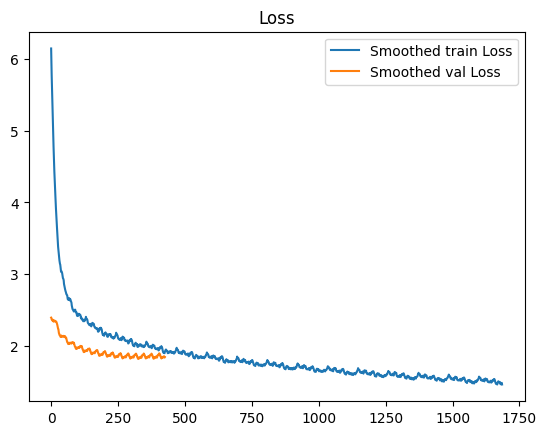

100%|██████████| 2000/2000 [01:59<00:00, 16.76it/s]


In [17]:
model = Model(learning_rate=0.0005, hidden_dim=256, ff_dim=1024, n_layers=2, dropout=0.2)
model.train()
model.draw_loss()
model.save_result()